In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset from the CSV file
try:
    df = pd.read_csv('results.csv')
    print("CSV file loaded successfully.")
except FileNotFoundError:
    print("Error: 'results.csv' not found. Please ensure the file is in the correct directory.")
    exit()

# --- Data Preprocessing ---

# Calculate Transaction Success Rate
# Assuming 50 is the max number of legitimate transactions attempted in each run
MAX_TRANSACTIONS = 50 
df['Transaction_Success_Rate'] = (df['Successful_Transactions'] / MAX_TRANSACTIONS) * 100

# Create a clear label for the slice choice based on scrubber type
# In the paper, this will be described as the outcome of using different utility weights
def assign_slice_label(choice):
    if choice in ['SW1', 'SW2']:
        return 'Slice prioritizing Speed (High α)'
    elif choice in ['SW3', 'SW4']:
        return 'Slice prioritizing Power (High θ)'
    else:
        return 'Centralized'
df['Slice_Type'] = df['Scrubber_Choice'].apply(assign_slice_label)

# Filter for the relevant data: Distributed scenarios with varying complexity
df_dist = df[df['Scenario_Type'] == 'Distributed'].copy()

print("\nData preprocessed. Key columns created:")
df[['Run_ID', 'Slice_Type', 'Attack_Style2_Multiplier', 'Transaction_Success_Rate']].head()

CSV file loaded successfully.

Data preprocessed. Key columns created:


,Run_ID,Slice_Type,Attack_Style2_Multiplier,Transaction_Success_Rate
0,Dist-GoodQ_pps-5000_fw-8000_mult-10,Slice prioritizing Power (High θ),10.0,96.0
1,Dist-WideP_pps-5000_fw-8000_mult-10,Slice prioritizing Speed (High α),10.0,96.0
2,Dist-GoodQ_pps-5000_fw-8000_mult-20,Slice prioritizing Power (High θ),20.0,96.0
3,Dist-WideP_pps-5000_fw-8000_mult-20,Slice prioritizing Speed (High α),20.0,72.0
4,Dist-GoodQ_pps-5000_fw-8000_mult-30,Slice prioritizing Power (High θ),30.0,96.0


CSV file loaded successfully.

Data filtered for plotting. Total rows: 270


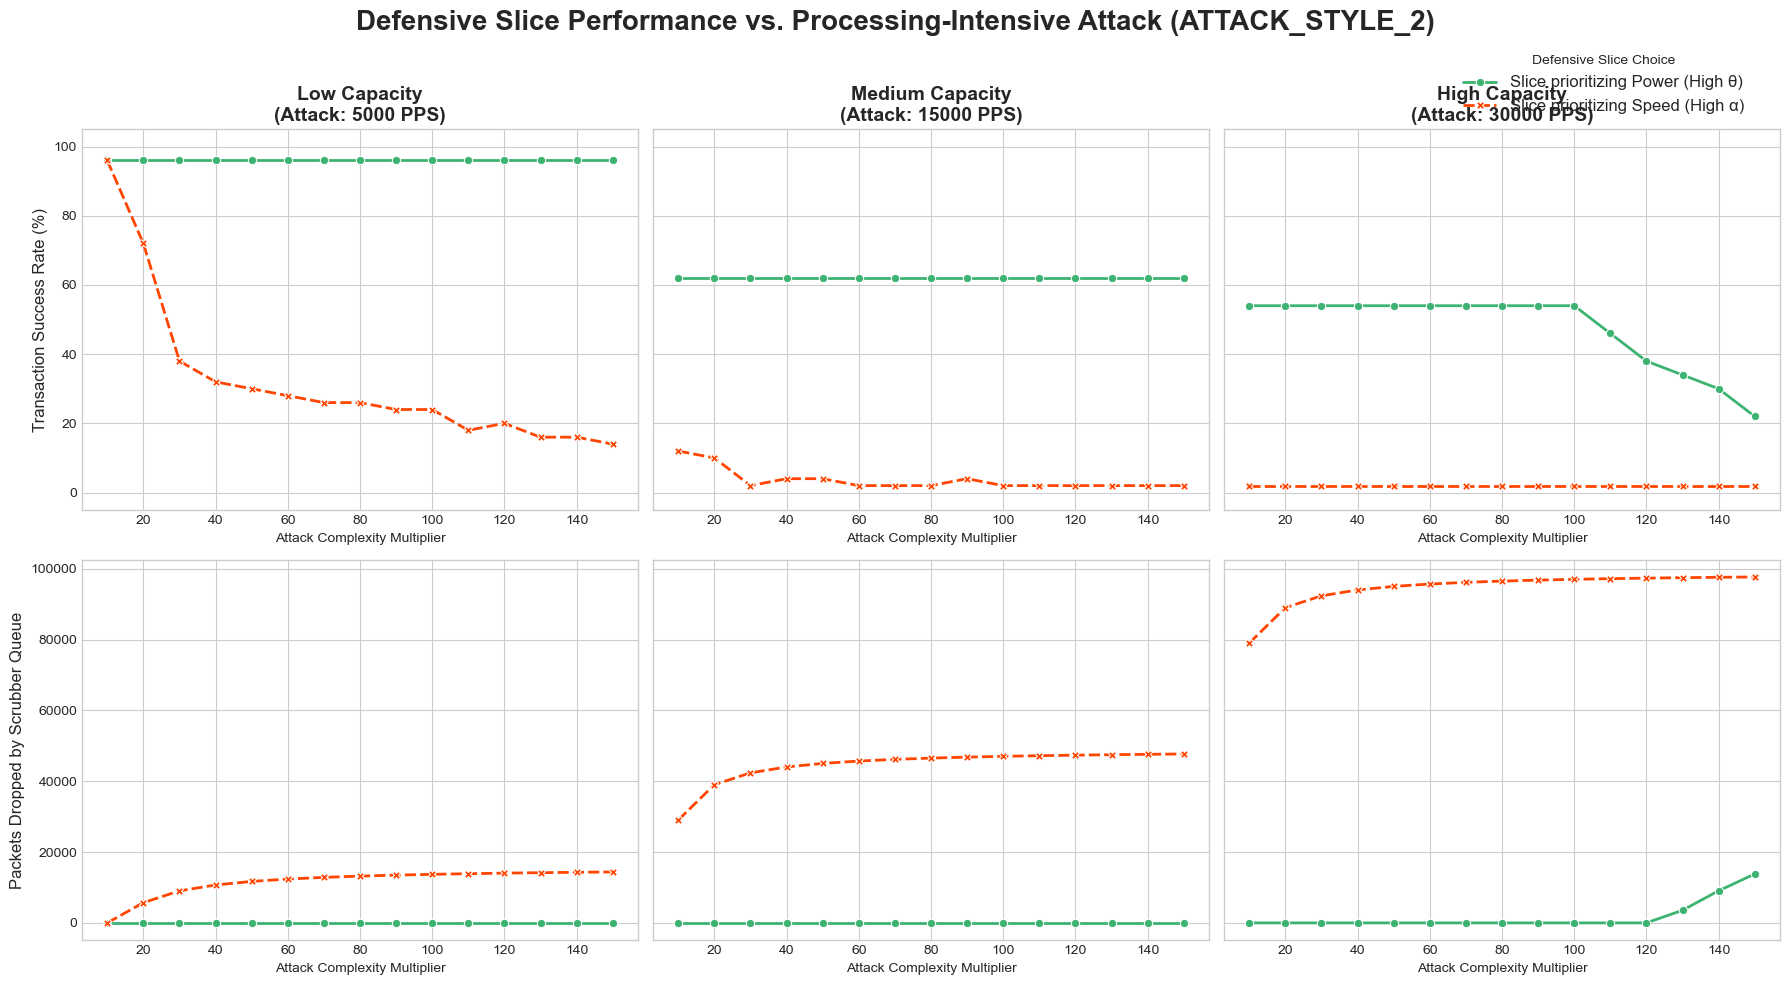

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Preprocess Data ---

try:
    df = pd.read_csv('results.csv')
    print("CSV file loaded successfully.")
except FileNotFoundError:
    print("Error: 'results.csv' not found. Please ensure the file is in the correct directory.")
    exit()

# Preprocessing steps from before
MAX_TRANSACTIONS = 50
df['Transaction_Success_Rate'] = (df['Successful_Transactions'] / MAX_TRANSACTIONS) * 100

def assign_slice_label(choice):
    if choice in ['SW1', 'SW2']:
        return 'Slice prioritizing Speed (High α)'
    elif choice in ['SW3', 'SW4']:
        return 'Slice prioritizing Power (High θ)'
    else:
        # This will catch the Centralized runs if we need them later
        return 'Centralized'
df['Slice_Type'] = df['Scrubber_Choice'].apply(assign_slice_label)

# Filter for the scenarios we want to plot
# We want distributed runs for ATTACK_STYLE_2 only
df_plot = df[(df['Scenario_Type'] == 'Distributed') & (df['Attack_Style'] == 'ATTACK_STYLE_2')].copy()

print("\nData filtered for plotting. Total rows:", len(df_plot))


# --- 2. Create the Subplot Grid ---

# Define the scenarios for our columns
scenarios = {
    'Low Capacity': {'Attack_PPS': 5000, 'FW_PPS_Capacity': 8000},
    'Medium Capacity': {'Attack_PPS': 15000, 'FW_PPS_Capacity': 20000},
    'High Capacity': {'Attack_PPS': 30000, 'FW_PPS_Capacity': 40000}
}

# Create the 2x3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey='row')
fig.suptitle('Defensive Slice Performance vs. Processing-Intensive Attack (ATTACK_STYLE_2)', fontsize=20, weight='bold')

# Define a consistent color palette
palette = {
    'Slice prioritizing Power (High θ)': 'mediumseagreen',
    'Slice prioritizing Speed (High α)': 'orangered'
}

# --- 3. Loop Through Scenarios and Populate Subplots ---

for i, (scenario_name, params) in enumerate(scenarios.items()):
    # Filter the data for the current column's scenario
    scenario_data = df_plot[
        (df_plot['Attack_PPS'] == params['Attack_PPS']) &
        (df_plot['FW_PPS_Capacity'] == params['FW_PPS_Capacity'])
    ]

    # --- Top Row: Transaction Success Rate ---
    ax_top = axes[0, i]
    sns.lineplot(
        data=scenario_data,
        x='Attack_Style2_Multiplier',
        y='Transaction_Success_Rate',
        hue='Slice_Type',
        palette=palette,
        style='Slice_Type',
        markers=True,
        linewidth=2,
        ax=ax_top
    )
    ax_top.set_title(f'{scenario_name}\n(Attack: {params["Attack_PPS"]} PPS)', fontsize=14, weight='bold')
    ax_top.set_xlabel('Attack Complexity Multiplier', fontsize=10)
    ax_top.set_ylim(-5, 105)
    if i == 0:
        ax_top.set_ylabel('Transaction Success Rate (%)', fontsize=12)
    else:
        ax_top.set_ylabel('')
    ax_top.legend().set_visible(False) # Hide individual legends

    # --- Bottom Row: Scrubber Queue Drops ---
    ax_bottom = axes[1, i]
    sns.lineplot(
        data=scenario_data,
        x='Attack_Style2_Multiplier',
        y='S1_Dropped_Queue', # Diagnostic metric
        hue='Slice_Type',
        palette=palette,
        style='Slice_Type',
        markers=True,
        linewidth=2,
        ax=ax_bottom
    )
    ax_bottom.set_xlabel('Attack Complexity Multiplier', fontsize=10)
    if i == 0:
        ax_bottom.set_ylabel('Packets Dropped by Scrubber Queue', fontsize=12)
    else:
        ax_bottom.set_ylabel('')
    ax_bottom.legend().set_visible(False)

# --- 4. Final Touches and Legend ---

# Create a single, shared legend for the entire figure
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.98, 0.95), title='Defensive Slice Choice', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.savefig("figure_grid_style2_attack.png", dpi=300)
plt.show()

New 'results_style_1.csv' loaded successfully.

Calculated RTT Percentage Increase:
Slice_Type  Attack_PPS  FW_PPS_Capacity  RTT_Power_Slice  RTT_Speed_Slice  \
0                60000            12000           249.86           159.87   
1               180000             8000           198.53           124.60   
2               180000            12000           450.11           379.84   
3               250000             8000           136.53            62.28   
4               250000            12000           178.54           104.85   
5               350000             8000            96.34            23.38   
6               350000            12000           110.73            37.77   

Slice_Type  RTT_Percent_Increase  
0                      56.289485  
1                      59.333868  
2                      18.499895  
3                     119.219653  
4                      70.281354  
5                     312.061591  
6                     193.169182  


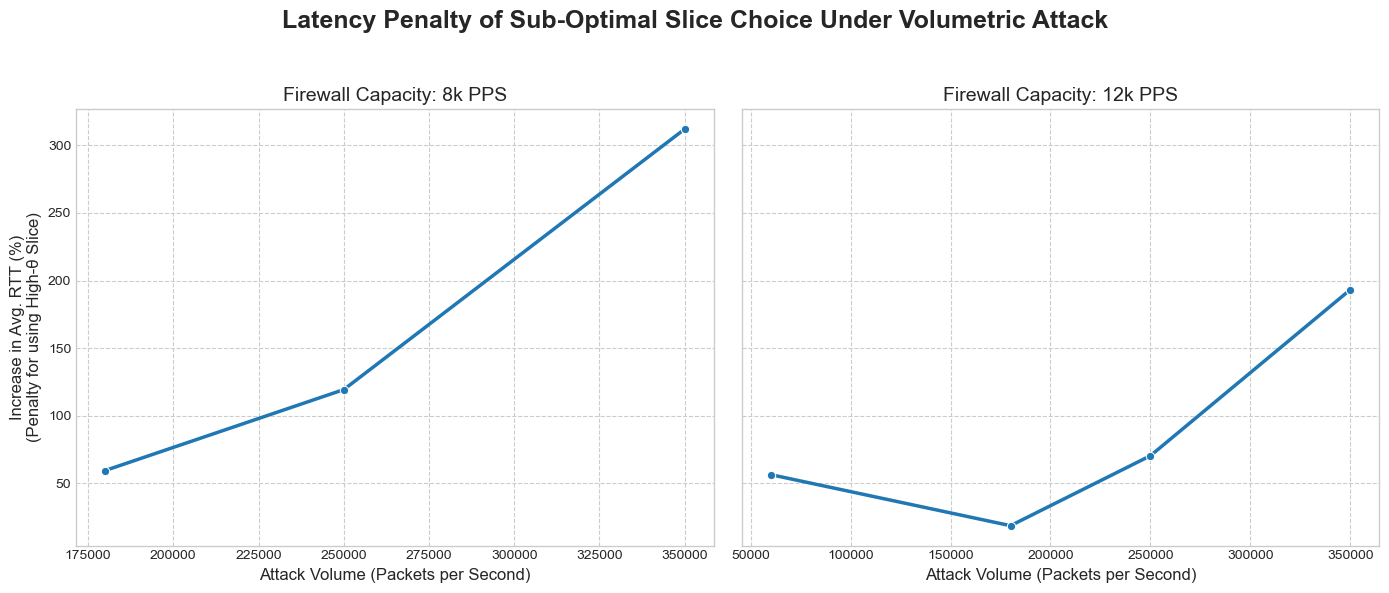

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Preprocess the New Data ---
try:
    df = pd.read_csv('results_style_1.csv')
    print("New 'results_style_1.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: 'results_style_1.csv' not found. Please ensure the file is in the correct directory.")
    exit()

# --- Preprocessing ---
def assign_slice_label(choice):
    if choice in ['SW1', 'SW2']:
        return 'Slice prioritizing Speed (High α)'
    elif choice in ['SW3', 'SW4']:
        return 'Slice prioritizing Power (High θ)'
    return 'N/A'
df['Slice_Type'] = df['Scrubber_Choice'].apply(assign_slice_label)

# --- 2. Calculate the Percentage RTT Difference ---

# Pivot the table to get RTTs for both slice types in the same row for easy calculation
df_pivot = df.pivot_table(
    index=['Attack_PPS', 'FW_PPS_Capacity'],
    columns='Slice_Type',
    values='Avg_RTT_ms'
).reset_index()

# Rename columns for clarity
df_pivot.rename(columns={
    'Slice prioritizing Speed (High α)': 'RTT_Speed_Slice',
    'Slice prioritizing Power (High θ)': 'RTT_Power_Slice'
}, inplace=True)

# Calculate the percentage increase
df_pivot['RTT_Percent_Increase'] = (
    (df_pivot['RTT_Power_Slice'] - df_pivot['RTT_Speed_Slice']) / df_pivot['RTT_Speed_Slice']
) * 100

print("\nCalculated RTT Percentage Increase:")
print(df_pivot)


# --- 3. Create the Subplot Figure ---

# Define firewall capacities for the subplots
fw_capacities = sorted(df_pivot['FW_PPS_Capacity'].unique())
fig, axes = plt.subplots(1, len(fw_capacities), figsize=(14, 6), sharey=True)
fig.suptitle('Latency Penalty of Sub-Optimal Slice Choice Under Volumetric Attack', fontsize=18, weight='bold')

# --- 4. Populate Subplots ---
for i, capacity in enumerate(fw_capacities):
    ax = axes[i]
    scenario_data = df_pivot[df_pivot['FW_PPS_Capacity'] == capacity]

    sns.lineplot(
        data=scenario_data,
        x='Attack_PPS',
        y='RTT_Percent_Increase',
        marker='o',
        linewidth=2.5,
        ax=ax
    )
    
    # Formatting
    ax.set_title(f'Firewall Capacity: {int(capacity/1000)}k PPS', fontsize=14)
    ax.set_xlabel('Attack Volume (Packets per Second)', fontsize=12)
    ax.grid(True, which='both', linestyle='--')
    
    # Set y-axis label only for the first plot
    if i == 0:
        ax.set_ylabel('Increase in Avg. RTT (%)\n(Penalty for using High-θ Slice)', fontsize=12)

# --- 5. Final Touches ---
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig("figure_final_rtt_penalty.png", dpi=300)
plt.show()

New 'results_style_1.csv' loaded successfully.

Data preprocessed.


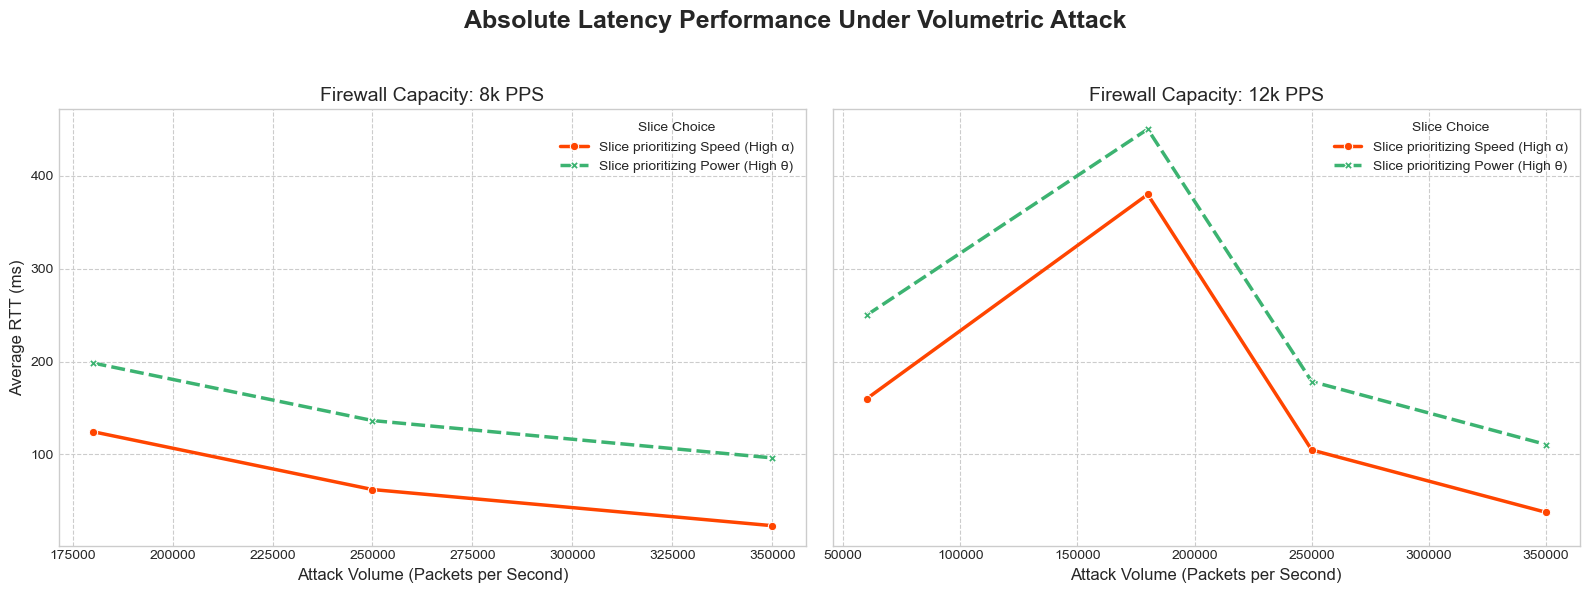


Calculated RTT Percentage Increase:
Slice_Type  Attack_PPS  FW_PPS_Capacity  RTT_Power_Slice  RTT_Speed_Slice  \
0                60000            12000           249.86           159.87   
1               180000             8000           198.53           124.60   
2               180000            12000           450.11           379.84   
3               250000             8000           136.53            62.28   
4               250000            12000           178.54           104.85   
5               350000             8000            96.34            23.38   
6               350000            12000           110.73            37.77   

Slice_Type  RTT_Percent_Increase  
0                      56.289485  
1                      59.333868  
2                      18.499895  
3                     119.219653  
4                      70.281354  
5                     312.061591  
6                     193.169182  


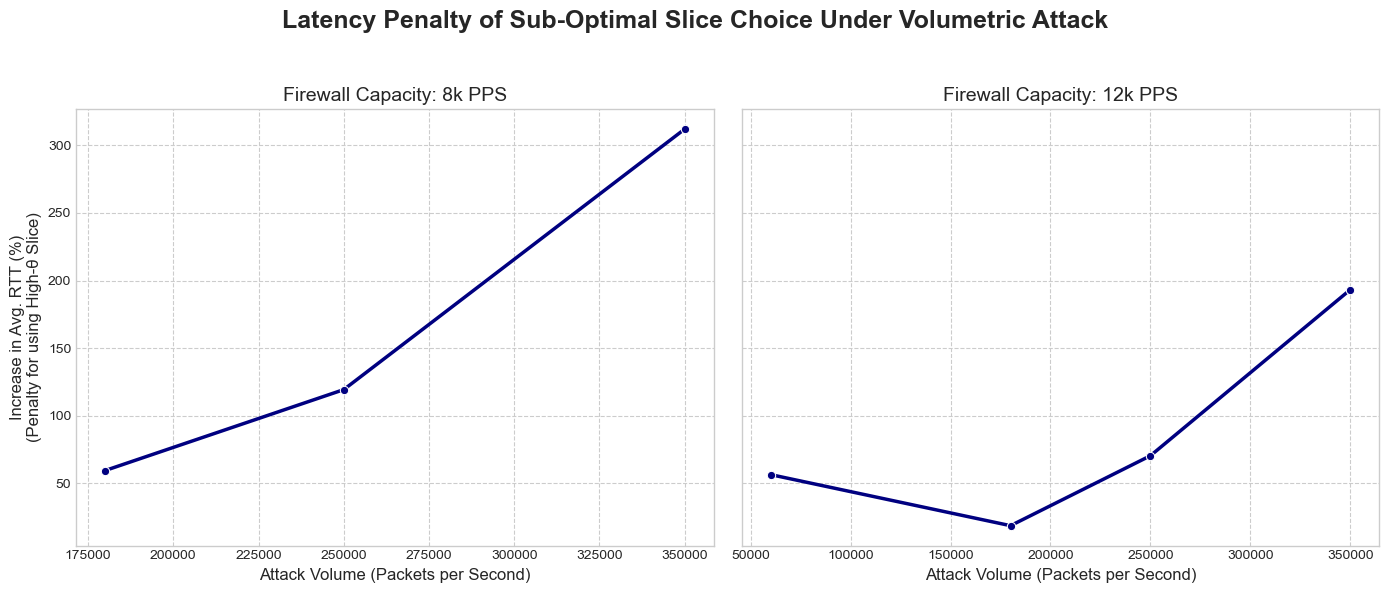

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Preprocess the Data ---
try:
    df = pd.read_csv('results_style_1.csv')
    print("New 'results_style_1.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: 'results_style_1.csv' not found. Please ensure the file is in the correct directory.")
    exit()

# --- Preprocessing ---
def assign_slice_label(choice):
    if choice in ['SW1', 'SW2']:
        return 'Slice prioritizing Speed (High α)'
    elif choice in ['SW3', 'SW4']:
        return 'Slice prioritizing Power (High θ)'
    return 'N/A'
df['Slice_Type'] = df['Scrubber_Choice'].apply(assign_slice_label)
df['Firewall Capacity'] = df['FW_PPS_Capacity'].apply(lambda x: f"{int(x/1000)}k PPS")
print("\nData preprocessed.")

# ==============================================================================
# FIGURE A: Raw Average RTT Comparison
# ==============================================================================

fig_a, axes_a = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
fig_a.suptitle('Absolute Latency Performance Under Volumetric Attack', fontsize=18, weight='bold')

palette = {
    'Slice prioritizing Power (High θ)': 'mediumseagreen',
    'Slice prioritizing Speed (High α)': 'orangered'
}

# Define the unique firewall capacities for the subplots
fw_capacities = sorted(df['FW_PPS_Capacity'].unique())

for i, capacity_val in enumerate(fw_capacities):
    ax = axes_a[i]
    scenario_data = df[df['FW_PPS_Capacity'] == capacity_val]
    
    sns.lineplot(
        data=scenario_data,
        x='Attack_PPS',
        y='Avg_RTT_ms',
        hue='Slice_Type',
        palette=palette,
        style='Slice_Type',
        markers=True,
        linewidth=2.5,
        ax=ax
    )
    
    ax.set_title(f'Firewall Capacity: {int(capacity_val/1000)}k PPS', fontsize=14)
    ax.set_xlabel('Attack Volume (Packets per Second)', fontsize=12)
    ax.grid(True, which='both', linestyle='--')
    ax.legend(title='Slice Choice')

    if i == 0:
        ax.set_ylabel('Average RTT (ms)', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig("figure_a_raw_rtt.png", dpi=300)
plt.show()


# ==============================================================================
# FIGURE B: Percentage RTT Increase (Performance Penalty)
# ==============================================================================

# --- 2. Calculate the Percentage RTT Difference ---
df_pivot = df.pivot_table(
    index=['Attack_PPS', 'FW_PPS_Capacity'],
    columns='Slice_Type',
    values='Avg_RTT_ms'
).reset_index()

df_pivot.rename(columns={
    'Slice prioritizing Speed (High α)': 'RTT_Speed_Slice',
    'Slice prioritizing Power (High θ)': 'RTT_Power_Slice'
}, inplace=True)

df_pivot['RTT_Percent_Increase'] = (
    (df_pivot['RTT_Power_Slice'] - df_pivot['RTT_Speed_Slice']) / df_pivot['RTT_Speed_Slice']
) * 100

print("\nCalculated RTT Percentage Increase:")
print(df_pivot)


# --- 3. Create the Percentage Difference Subplot Figure ---
fig_b, axes_b = plt.subplots(1, len(fw_capacities), figsize=(14, 6), sharey=True)
fig_b.suptitle('Latency Penalty of Sub-Optimal Slice Choice Under Volumetric Attack', fontsize=18, weight='bold')

for i, capacity_val in enumerate(fw_capacities):
    ax = axes_b[i]
    scenario_data = df_pivot[df_pivot['FW_PPS_Capacity'] == capacity_val]

    sns.lineplot(
        data=scenario_data,
        x='Attack_PPS',
        y='RTT_Percent_Increase',
        marker='o',
        linewidth=2.5,
        color='navy', # Use a single color as we are showing a derived value
        ax=ax
    )
    
    ax.set_title(f'Firewall Capacity: {int(capacity_val/1000)}k PPS', fontsize=14)
    ax.set_xlabel('Attack Volume (Packets per Second)', fontsize=12)
    ax.grid(True, which='both', linestyle='--')
    
    if i == 0:
        ax.set_ylabel('Increase in Avg. RTT (%)\n(Penalty for using High-θ Slice)', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig("figure_b_rtt_penalty.png", dpi=300)
plt.show()